In [ ]:
# Import of required libraries
import re #regex
import nltk #tokenizer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout 
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot #one hot encoding
from tensorflow.keras.preprocessing.sequence import pad_sequences #padding
from sklearn.metrics import classification_report 
#individual performance evaluation are imported below
#https://www.kaggle.com/c/fake-news/data?select=train.csv dataset that was used

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from google.colab import files
upload = files.upload()

Saving fakenews.zip to fakenews.zip


In [ ]:
!unzip fakenews.zip

Archive:  fakenews.zip
  inflating: train.csv               


In [ ]:
 df = pd.read_csv("train.csv")
#df.head() #1 = fake 0 = true
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


Looking at the Dataset

In [ ]:
df['title'][3]

'15 Civilians Killed In Single US Airstrike Have Been Identified'

In [ ]:
df['label'][4]

1

In [ ]:
df.shape

(20800, 5)

In [ ]:
#checking for null values
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [ ]:
 #drop missing data
 # author is not dropped because it is inconsequential ( we are looking at the title/text to determine the true/false of a news article)
 df = df.dropna(subset=['title','text'])
df.isnull().sum()

id           0
title        0
author    1918
text         0
label        0
dtype: int64

Classifying Data

In [ ]:
x = df.drop(columns='label')
y = df['label']

In [ ]:
x.shape, y.shape#array dimensions 

((20203, 4), (20203,))

In [ ]:
#create shallow copy - create a new object
copy = x.copy()
#copies the reference of nested objects
copy.reset_index(inplace=True)

In [ ]:
ws = WordNetLemmatizer()
list_titles = []
for i in range(0, len(copy)):
  headline = re.sub('[^a-zA-Z]', ' ', copy['title'][i])
  #Regex is used to match the text (from a-z/A-z)  copy is used to lemmatize the words
  #Using the ^ operator, ^ matches any character that does not appear inside the brackets
  headline = headline.lower()
  headline = headline.split()
  headline = [ws.lemmatize(word) for word in headline if word not in stopwords.words("english")]
  headline = ' '.join(headline)
  list_titles.append(headline) #adds a single item to the existing list

In [ ]:
list_titles[:4]

['house dem aide even see comey letter jason chaffetz tweeted',
 'flynn hillary clinton big woman campus breitbart',
 'truth might get fired',
 'civilian killed single u airstrike identified']

In [ ]:
#defining vocab using keras one_hot
# encode each word to an integer, the corresponding index(integer) is sourced from the dictionary
#the integer might not necessarily be the same but will produce similar results
vocab = 10000
hot_title = [one_hot(i, vocab) for i in list_titles]
hot_title[:4]

[[7313, 5301, 7950, 6219, 3159, 9098, 8555, 1171, 3844, 5142],
 [5601, 9103, 656, 5782, 4869, 4948, 457],
 [500, 6178, 3595, 4630],
 [3513, 317, 1657, 9321, 2110, 3708]]

In [ ]:
#longest sentence
longest_sentence = len(max(list_titles, key = len))
longest_sentence 

356

In [ ]:
#making every sentence the same length with padding
embed_input = pad_sequences(hot_title, maxlen = longest_sentence, padding='pre')
print(embed_input)

[[   0    0    0 ... 1171 3844 5142]
 [   0    0    0 ... 4869 4948  457]
 [   0    0    0 ... 6178 3595 4630]
 ...
 [   0    0    0 ... 8939 7123 5003]
 [   0    0    0 ... 1570 5952  536]
 [   0    0    0 ... 2919 9562 6571]]


Creating the model

In [ ]:
model = Sequential() #creating the sequential model incrementally via the add() method
model.add(Embedding(input_dim=vocab, output_dim= 40, input_length=356)) #output_dim can be tweaked
model.add(LSTM(150))
model.add(Dense(1, activation='sigmoid'))#sigmoid returns a value close to zero since it is binary classification
#config the model with losses (binary_crossentropy), optimizer(adam which solves for gradient descent) and metrics (accuracy) - compile()
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 356, 40)           400000    
                                                                 
 lstm (LSTM)                 (None, 150)               114600    
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 514,751
Trainable params: 514,751
Non-trainable params: 0
_________________________________________________________________
None


Describing model

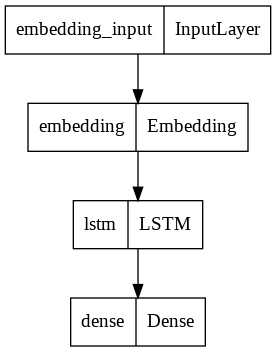

In [ ]:
plot_model(model)


In [ ]:
len(embed_input),y.shape

(20203, (20203,))

In [ ]:
x_final = np.array(embed_input)
y_final = np.array(y)
x_final.shape, y_final.shape 

((20203, 356), (20203,))

In [ ]:
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.33, random_state=42)

In [ ]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64) 

Epoch 1/10
212/212 [==============================] - 176s 816ms/step - loss: 0.7184 - accuracy: 0.7708 - val_loss: 0.2213 - val_accuracy: 0.9178
Epoch 2/10
212/212 [==============================] - 172s 810ms/step - loss: 0.1639 - accuracy: 0.9391 - val_loss: 0.1718 - val_accuracy: 0.9331
Epoch 3/10
212/212 [==============================] - 172s 813ms/step - loss: 0.0949 - accuracy: 0.9668 - val_loss: 0.1910 - val_accuracy: 0.9325
Epoch 4/10
212/212 [==============================] - 172s 811ms/step - loss: 0.0843 - accuracy: 0.9729 - val_loss: 0.2178 - val_accuracy: 0.9252
Epoch 5/10
212/212 [==============================] - 172s 813ms/step - loss: 0.0482 - accuracy: 0.9860 - val_loss: 0.2409 - val_accuracy: 0.9223
Epoch 6/10
212/212 [==============================] - 171s 809ms/step - loss: 0.0312 - accuracy: 0.9912 - val_loss: 0.3021 - val_accuracy: 0.9154
Epoch 7/10
212/212 [==============================] - 171s 808ms/step - loss: 0.0217 - accuracy: 0.9943 - val_loss: 0.3402 -

Performance testing

In [ ]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred).astype(int)
print(y_pred)


[[1]
 [1]
 [0]
 ...
 [1]
 [1]
 [1]]


In [ ]:
print(y_test)

[1 1 0 ... 1 1 1]


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred,normalize=True)

0.9158542072896355

In [ ]:
 from sklearn.metrics import confusion_matrix
 confusion_matrix(y_test, y_pred)

array([[3121,  299],
       [ 262, 2985]])

In [ ]:
model.evaluate(embed_input, y)

632/632 [==============================] - 76s 119ms/step - loss: 0.1370 - accuracy: 0.9716


[0.13704369962215424, 0.9716379046440125]

In [ ]:
#Classification report includes precision, recall, f1-score
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
#Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      3420
           1       0.91      0.92      0.91      3247

    accuracy                           0.92      6667
   macro avg       0.92      0.92      0.92      6667
weighted avg       0.92      0.92      0.92      6667



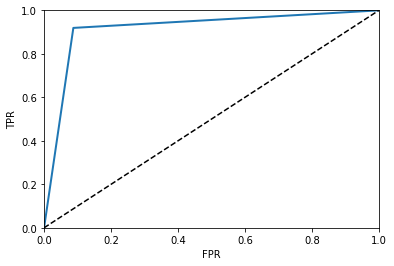

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt 

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)
#good score

0.9159416159225701